# Homework 2

## Roger Garriga, Javier Mas, José Fernando Moreno

In [6]:
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
#import lda
from collections import Counter
import scipy.sparse as ssp
import topicmodels as tpm
import matplotlib.pyplot as plt


### Exercise 2


Iteration 1 of (collapsed) Gibbs sampling
Iteration 2 of (collapsed) Gibbs sampling
Iteration 3 of (collapsed) Gibbs sampling
Iteration 4 of (collapsed) Gibbs sampling
Iteration 5 of (collapsed) Gibbs sampling
Iteration 6 of (collapsed) Gibbs sampling
Iteration 7 of (collapsed) Gibbs sampling
Iteration 8 of (collapsed) Gibbs sampling
Iteration 9 of (collapsed) Gibbs sampling
Iteration 10 of (collapsed) Gibbs sampling
Iteration 1 of (collapsed) Gibbs sampling
Iteration 2 of (collapsed) Gibbs sampling
Iteration 3 of (collapsed) Gibbs sampling
Iteration 4 of (collapsed) Gibbs sampling
Iteration 5 of (collapsed) Gibbs sampling
Iteration 6 of (collapsed) Gibbs sampling
Iteration 7 of (collapsed) Gibbs sampling
Iteration 8 of (collapsed) Gibbs sampling
Iteration 9 of (collapsed) Gibbs sampling
Iteration 10 of (collapsed) Gibbs sampling
Iteration 1 of (collapsed) Gibbs sampling
Iteration 2 of (collapsed) Gibbs sampling
Iteration 3 of (collapsed) Gibbs sampling
Iteration 4 of (collapsed) Gibbs

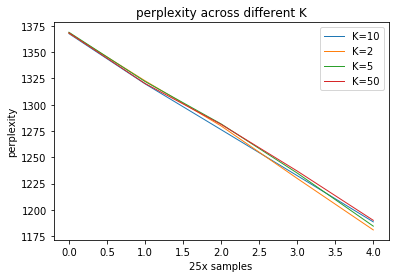

In [7]:
path = "/home/roger/Desktop/BGSE/courses/14D010 Text Mining for Social Sciences/Text-Mining/hw1"

data = pd.read_table(path+"/speech_data_extend.txt", encoding="utf-8")

data = data.loc[data['year']>=1946]
data = data.reset_index()
#Tokenize

def tok_stem_data(data):
    
    prep_data = data.apply(lambda row: 
                            nltk.word_tokenize(row['speech'].lower()), axis=1)
    
    #Remove stop words and non-alphanumeric characters
    
    stop_w=set(stopwords.words('english'))
    
    
    for i in range(len(prep_data)):
        prep_data[i] = [w for w in prep_data[i] if w not in stop_w and w.isalpha()]
    
    #Stem the data
    
    stemmer = PorterStemmer() #Create a stemmer object
    
    for i in range(len(prep_data)):
        prep_data[i] = [stemmer.stem(elem) for elem in prep_data[i]]
        
    empty_str = [i for i in range(len(prep_data)) if len(prep_data[i]) == 0]        

    prep_data = prep_data.drop(empty_str)
    
    prep_data = prep_data.reset_index()
    del prep_data['index']
    prep_data.columns = ['speech']
    prep_data = pd.Series(prep_data['speech'])
    
    return prep_data

def count_words(prep_data):
    unique_words = np.unique([word for doc in prep_data for word in doc])
    unique_words = dict(zip(unique_words,range(len(unique_words))))
    D = len(prep_data)
    V = len(unique_words)
    unigram_data = [[word for word in doc] for doc in prep_data]
    X = np.zeros((D,V))
    for k in range(D):
        counts = Counter(unigram_data[k])
        for word in set(unigram_data[k]):
            X[k,unique_words[word]] = counts[word]    
    X = ssp.csr_matrix(X.astype(int))
    return X

prep_data=tok_stem_data(data)

perps = {}
K = [2,5,10,50]
for k in [2,5,10,50]:
    
    Col_Gibbs = tpm.LDA.LDAGibbs(prep_data,50)
    burn_samples = 0
    jumps = 25
    used_samples = 150

    Col_Gibbs.sample(burn_samples,jumps,used_samples)

    perp_coll = Col_Gibbs.perplexity()

    perps[str((k,Col_Gibbs.alpha,0.0241))] = perp_coll
    
a = [10,2,5,50]
i = 0
for item in perps:
    plt.plot(perps[item], lw = 1., label = 'K='+str(a[i]))
    plt.legend()
    plt.ylabel('perplexity')
    plt.xlabel('25x samples')
    plt.title('perplexity across different K')
    i+=1
    
    